# **Giới thiệu bài toán ứng dụng K-Mean trong marketing**
![alt text](http://vukhuc.000webhostapp.com/cotai/pics/kmean_bike_db_diagram.png)

1. Yêu cầu bài toán:
 - Chúng ta đóng vai trò là doanh nghiệp sản xuất xe đạp, sản xuất 97 loại xe với các phân loại khác nhau. Khách hàng của chúng ta là những đại lý bán lẻ.
 - Dựa vào dữ liệu lịch sử, phân tích để hiểu những gì đã xảy ra trong quá khứ.
 - Đưa ra khuyến nghị cho chiến lược kinh doanh sắp tới.
2. Ý nghĩa từng table:
 - Bikes (97,6): thông tin các loại xe đạp
 - Bikeshops (30,6): thông tin các đại lý (khách hàng mua xe đạp)
 - Orders (15644,6): đơn hàng bán cho các đại lý (khách hàng mua xe đạp)
3. Kết quả đạt được sau khi làm bài lab:
 - Hiểu được các sử dụng thư viện pandas để xử lý dữ liệu có cấu trúc
 - Biết sử dụng KMean, tìm k tối ưu và cách visualize dữ liệu bằng seaborn
 - Biết cách phân tích một bài toán thực tế ở mức độ đơn giản

In [0]:
import pandas as pd
import numpy as np
import seaborn as sns

# 1. Đọc dữ từ GDrive để tạo dataframe

In [2]:
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/My Drive/Colab Notebooks/cotai/kmean/kmean_data'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive/Colab Notebooks/cotai/kmean/kmean_data


In [3]:
df_bikes = pd.read_csv('bikes.csv')
print(df_bikes.shape)
df_bikes.head(3)

(97, 6)


,bike.id,model,category1,category2,frame,price
0,1,Supersix Evo Black Inc.,Road,Elite Road,Carbon,12790
1,2,Supersix Evo Hi-Mod Team,Road,Elite Road,Carbon,10660
2,3,Supersix Evo Hi-Mod Dura Ace 1,Road,Elite Road,Carbon,7990


In [4]:
df_bikeshops = pd.read_csv('bikeshops.csv')
print(df_bikeshops.shape)
df_bikeshops.head(3)

(30, 6)


,bikeshop.id,bikeshop.name,bikeshop.city,bikeshop.state,latitude,longitude
0,1,Pittsburgh Mountain Machines,Pittsburgh,PA,40.440625,-79.995886
1,2,Ithaca Mountain Climbers,Ithaca,NY,42.443961,-76.501881
2,3,Columbus Race Equipment,Columbus,OH,39.961176,-82.998794


In [5]:
df_orders = pd.read_csv('orders.csv',index_col=0)
# df_orders[df_orders['order.id']==1]
print(df_orders.shape)
df_orders.head(3)

(15644, 6)


,order.id,order.line,order.date,customer.id,product.id,quantity
1,1,1,1/7/2011,2,48,1
2,1,2,1/7/2011,2,52,1
3,2,1,1/10/2011,10,76,1


# 2. Join các dataframe với nhau để flattern dữ liệu

In [27]:
df_merge = df_orders.merge(right=df_bikes,how='inner',left_on='product.id', right_on='bike.id')
df_merge = df_merge.merge(right=df_bikeshops,how='inner',left_on='customer.id',right_on='bikeshop.id')
df_merge = df_merge.groupby(['bikeshop.name','model','category1','category2','frame','price'])['quantity'].agg(quantity='sum').reset_index()
print(df_merge.shape)
df_merge.head(3)

(2513, 7)


,bikeshop.name,model,category1,category2,frame,price,quantity
0,Albuquerque Cycles,Bad Habit 1,Mountain,Trail,Aluminum,3200,5
1,Albuquerque Cycles,Bad Habit 2,Mountain,Trail,Aluminum,2660,2
2,Albuquerque Cycles,Beast of the East 1,Mountain,Trail,Aluminum,2770,3


# 3. Viết các hàm tiện ích  

In [0]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt

def clusterByKMean(X,k,col_cluster_name):
  kmeans = KMeans(n_clusters = k).fit(X)
  pred = kmeans.labels_
  return pd.concat([X,pd.DataFrame({'index':X.index,'cluster':pred}).set_index('index')], axis=1)
def drawSilhouette(X,n_MaxK,splt):
  sil = []
  K=range(2,n_MaxK)
  for k in K:
    kmeans = KMeans(n_clusters = k).fit(X)
    labels = kmeans.labels_
    sil.append(silhouette_score(X, labels, metric = 'euclidean'))
  # Plot the silhouette_score
  splt.plot(K, sil, 'bx-')
  splt.set_xlabel('k')
  splt.set_ylabel('silhouette score')
  splt.set_title('Silhouette Method')

def drawElbow(X,n_MaxK,splt):
  K=range(1,n_MaxK)
  W = []
  for k in K:
    kmeans = KMeans(n_clusters = k).fit(X)
    labels = kmeans.labels_
    W.append(sum(np.min(cdist(X, kmeans.cluster_centers_, 'euclidean'), axis=1)) / np.shape(X)[0])
  # Plot the elbow
  splt.plot(K, W, 'bx-')
  splt.set_xlabel('k')
  splt.set_ylabel('Distortion')
  splt.set_title('Elbow Method')

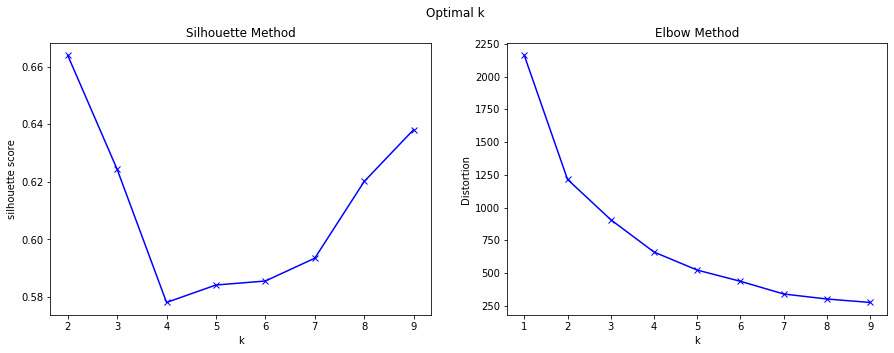

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
fig.suptitle('Optimal k')
drawSilhouette(df_merge[['price']],10,ax1)
drawElbow(df_merge[['price']],10,ax2)

# 4. Phân cụm giá sản phẩm

In [9]:
df=df_merge.copy(True)
df_price_temp = clusterByKMean(df[['price']],2,'cluster')
print(df_price_temp[df_price_temp.cluster==0]['price'].min())
print(df_price_temp[df_price_temp.cluster==0]['price'].max())
print(df_price_temp[df_price_temp.cluster==1]['price'].min())
print(df_price_temp[df_price_temp.cluster==1]['price'].max())
df['price'] = pd.cut(df_price_temp.price,bins=[415,4800,12790])
# df['price'] = pd.qcut(df_price_temp.price,2)
df['price'].astype(str)
df

415
4800
5330
12790


,bikeshop.name,model,category1,category2,frame,price,quantity
0,Albuquerque Cycles,Bad Habit 1,Mountain,Trail,Aluminum,"(415, 4800]",5
1,Albuquerque Cycles,Bad Habit 2,Mountain,Trail,Aluminum,"(415, 4800]",2
2,Albuquerque Cycles,Beast of the East 1,Mountain,Trail,Aluminum,"(415, 4800]",3
3,Albuquerque Cycles,Beast of the East 2,Mountain,Trail,Aluminum,"(415, 4800]",3
4,Albuquerque Cycles,Beast of the East 3,Mountain,Trail,Aluminum,"(415, 4800]",1
...,...,...,...,...,...,...,...
2508,Wichita Speed,Trail 2,Mountain,Sport,Aluminum,"(415, 4800]",1
2509,Wichita Speed,Trigger Carbon 1,Mountain,Over Mountain,Carbon,"(4800, 12790]",8
2510,Wichita Speed,Trigger Carbon 2,Mountain,Over Mountain,Carbon,"(4800, 12790]",2
2511,Wichita Speed,Trigger Carbon 3,Mountain,Over Mountain,Carbon,"(415, 4800]",9


# 5. Transform dữ liệu để KMean

In [10]:
df_t = pd.pivot_table(df,index=['model','category1','category2','frame','price'], columns=['bikeshop.name'], values=['quantity'])
df_t = df_t.reset_index()
df_t.drop(columns=['model','category1','category2','frame','price'],inplace=True)
df_t


/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:3946: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)


quantity                  ...                          
bikeshop.name Albuquerque Cycles Ann Arbor Speed  ... Tampa 29ers Wichita Speed
0                            5.0             4.0  ...         4.0           3.0
1                            2.0             6.0  ...         NaN           NaN
2                            3.0             9.0  ...         2.0           NaN
3                            3.0             6.0  ...         6.0           1.0
4                            1.0             2.0  ...         2.0           NaN
..                           ...             ...  ...         ...           ...
91                           3.0             7.0  ...         7.0           NaN
92                           2.0             NaN  ...         3.0           8.0
93                           1.0             NaN  ...         5.0           2.0
94                           2.0             NaN  ...         3.0           9.0
95                           2.0             7.0  ...         8.0           9.0

[96 rows x 30 columns]

# 6. Xử lý missing value và scale dữ liệu

In [11]:
df_t = df_t.fillna(0)
for col in df_t.columns:
  sum_value = df_t[col].sum()
  df_t[col] = df_t[col]*100/sum_value
df_k = df_t.T.reset_index().drop(columns=['level_0'], axis=1).set_index('bikeshop.name')
df_k


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95
bikeshop.name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Albuquerque Cycles,1.779359,0.711744,1.067616,1.067616,0.355872,1.423488,0.711744,0.000000,1.423488,4.982206,1.423488,1.423488,2.846975,0.711744,0.711744,1.067616,2.135231,1.423488,3.202847,1.067616,1.779359,1.779359,0.000000,1.779359,1.067616,0.355872,0.711744,1.423488,1.779359,2.135231,1.779359,1.067616,0.355872,0.355872,0.000000,0.000000,2.846975,1.067616,0.000000,0.000000,...,1.067616,1.423488,0.355872,0.711744,0.000000,1.067616,0.711744,0.000000,1.779359,0.355872,0.711744,0.711744,1.067616,0.711744,0.711744,2.135231,2.135231,1.423488,0.711744,0.355872,1.067616,1.067616,1.067616,2.846975,0.711744,1.779359,0.000000,2.491103,1.067616,0.355872,0.000000,0.000000,0.355872,0.711744,1.779359,1.067616,0.711744,0.355872,0.711744,0.711744
Ann Arbor Speed,0.667780,1.001669,1.502504,1.001669,0.333890,2.671119,1.502504,1.669449,1.502504,0.834725,2.671119,1.335559,2.337229,1.502504,1.836394,1.168614,0.667780,0.834725,0.667780,0.166945,0.333890,1.001669,0.000000,0.166945,1.001669,0.000000,0.000000,0.166945,0.500835,0.500835,0.667780,0.834725,0.000000,0.000000,0.166945,0.333890,0.166945,0.000000,0.166945,0.333890,...,2.671119,1.168614,0.667780,2.337229,2.504174,2.003339,2.170284,1.335559,0.834725,3.338898,0.834725,2.838063,1.502504,1.335559,2.003339,3.005008,2.170284,1.669449,0.834725,1.669449,0.834725,1.836394,3.338898,1.168614,0.834725,1.335559,0.500835,0.834725,1.335559,1.335559,1.001669,1.001669,1.502504,1.001669,0.333890,1.168614,0.000000,0.000000,0.000000,1.168614
Austin Cruisers,0.836820,0.418410,0.836820,0.836820,0.000000,2.092050,2.092050,0.418410,2.510460,0.836820,1.673640,3.347280,1.255230,2.928870,1.255230,1.673640,1.255230,0.836820,0.418410,1.255230,0.836820,0.418410,0.000000,0.418410,1.673640,0.000000,0.418410,0.418410,0.418410,0.418410,0.418410,2.510460,0.000000,0.000000,0.000000,0.418410,0.000000,0.000000,0.000000,0.000000,...,1.255230,2.510460,0.836820,0.000000,0.418410,1.255230,0.836820,0.418410,0.418410,1.255230,2.092050,2.510460,0.418410,5.439331,3.765690,1.673640,1.673640,1.255230,0.000000,0.000000,2.092050,2.092050,0.836820,2.092050,0.418410,2.928870,0.418410,1.673640,0.418410,0.836820,2.092050,1.673640,1.673640,1.673640,0.836820,0.836820,0.000000,0.000000,0.000000,1.673640
Cincinnati Speed,0.511509,0.000000,0.000000,0.000000,0.000000,1.534527,1.023018,1.534527,0.767263,1.790281,2.813299,0.767263,1.534527,0.767263,2.557545,0.255754,0.000000,0.000000,0.000000,0.000000,0.255754,0.255754,0.767263,0.767263,0.000000,2.301790,0.767263,0.255754,0.000000,0.000000,0.255754,0.000000,0.511509,1.023018,0.767263,1.023018,2.046036,0.511509,0.511509,0.511509,...,1.790281,1.278772,2.557545,1.023018,1.278772,0.767263,3.069054,0.767263,1.023018,1.790281,2.301790,1.534527,1.534527,2.557545,0.255754,0.511509,0.767263,1.278772,3.324808,1.790281,1.278772,0.767263,1.023018,1.023018,1.278772,1.278772,2.557545,1.534527,2.301790,1.790281,1.278772,0.000000,0.255754,0.255754,0.255754,0.000000,1.023018,0.767263,1.023018,2.046036
Columbus Race Equipment,1.017812,0.000000,0.000000,0.508906,0.254453,1.017812,2.798982,2.798982,2.544529,1.272265,1.781170,1.781170,1.526718,0.254453,0.763359,1.017812,0.000000,0.254453,0.000000,0.000000,0.000000,0.763359,0.508906,1.272265,0.254453,0.508906,1.272265,0.763359,0.000000,0.000000,0.000000,0.254453,1.017812,0.508906,2.290076,0.763359,1.017812,0.508906,0.763359,1.781170,...,2.035623,0.508906,1.526718,0.508906,2.035623,1.017812,0.254453,1.017812,1.017812,0.763359,1.272265,1.272265,1.017812,2.544529,0.000000,1.017812,1.272265,1.017812,2.798982,2.290076,0.254453,1.272265,1.017812,1.017812,0.508906,0.763359,2.035623,1.526718,1.781170,3.816794,1.526718,0.254453,0.254453,0.508906,0.000000,0.0

# 7. Tìm số cụm tối ưu và phân cụm
## 7.1 Tìm số cụm tối ưu

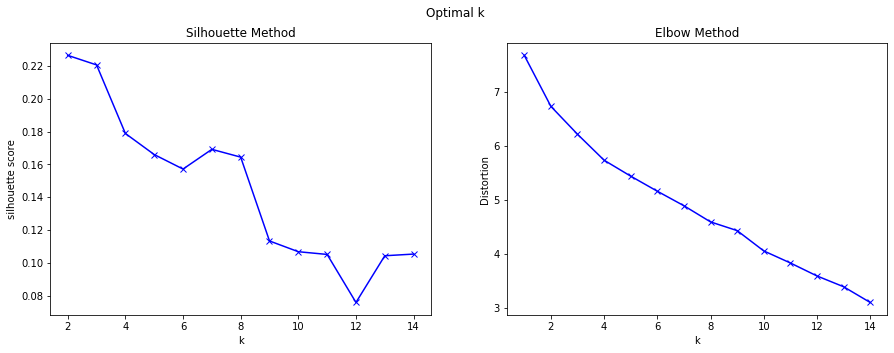

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
fig.suptitle('Optimal k')
drawSilhouette(df_k,15,ax1)
drawElbow(df_k,15,ax2)

## 7.2. Thực hiện phân cụm

In [13]:
df_r = clusterByKMean(df_k,4,'cluster')['cluster'].reset_index()
df_r.sort_values(by='cluster')

,index,cluster
22,Pittsburgh Mountain Machines,0
9,Ithaca Mountain Climbers,0
28,Tampa 29ers,0
14,Miami Race Equipment,1
1,Ann Arbor Speed,1
2,Austin Cruisers,1
27,Seattle Race Equipment,1
19,Oklahoma City Race Equipment,1
17,New Orleans Velocipedes,1
8,Indianapolis Velocipedes,1


## 7.3. Vẽ thử các cửa hàng về vị trí địa lý và giá trị cụm của nó
- Chúng ta phân cụm theo số lượng sản phẩm mà của hàng mua nên phân cụm này về lý thuyết sẽ không liên quan đến vị trí địa lý của cửa hàng

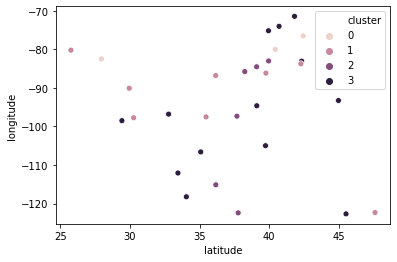

In [14]:
na_loc = pd.merge(df_bikeshops,df_r, how='right',right_on='index', left_on='bikeshop.name')
sns.scatterplot(data=na_loc,x='latitude',y='longitude',hue='cluster')
# na_loc.columns


# 8. Ghép dữ liệu sau khi phân cụm với dữ liệu ban đầu

In [15]:
df_c = pd.merge(df,df_r,how='left',left_on='bikeshop.name', right_on='index')
df_c

,bikeshop.name,model,category1,category2,frame,price,quantity,index,cluster
0,Albuquerque Cycles,Bad Habit 1,Mountain,Trail,Aluminum,"(415, 4800]",5,Albuquerque Cycles,3
1,Albuquerque Cycles,Bad Habit 2,Mountain,Trail,Aluminum,"(415, 4800]",2,Albuquerque Cycles,3
2,Albuquerque Cycles,Beast of the East 1,Mountain,Trail,Aluminum,"(415, 4800]",3,Albuquerque Cycles,3
3,Albuquerque Cycles,Beast of the East 2,Mountain,Trail,Aluminum,"(415, 4800]",3,Albuquerque Cycles,3
4,Albuquerque Cycles,Beast of the East 3,Mountain,Trail,Aluminum,"(415, 4800]",1,Albuquerque Cycles,3
...,...,...,...,...,...,...,...,...,...
2508,Wichita Speed,Trail 2,Mountain,Sport,Aluminum,"(415, 4800]",1,Wichita Speed,2
2509,Wichita Speed,Trigger Carbon 1,Mountain,Over Mountain,Carbon,"(4800, 12790]",8,Wichita Speed,2
2510,Wichita Speed,Trigger Carbon 2,Mountain,Over Mountain,Carbon,"(4800, 12790]",2,Wichita Speed,2
2511,Wichita Speed,Trigger Carbon 3,Mountain,Over Mountain,Carbon,"(415, 4800]",9,Wichita Speed,2


# 9. Plot dữ liệu sau khi phân cụm để hiểu rõ hơn từng cụm (dán nhãn cho từng cụm)

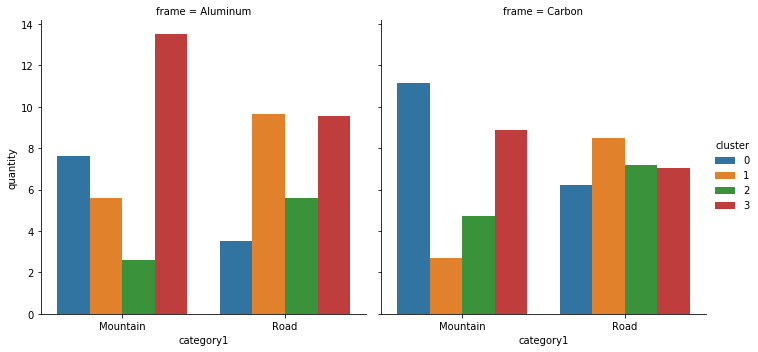

In [29]:
sns.catplot(data=df_c,x='category1',y='quantity', col='frame', kind='bar',hue='cluster',ci=None)

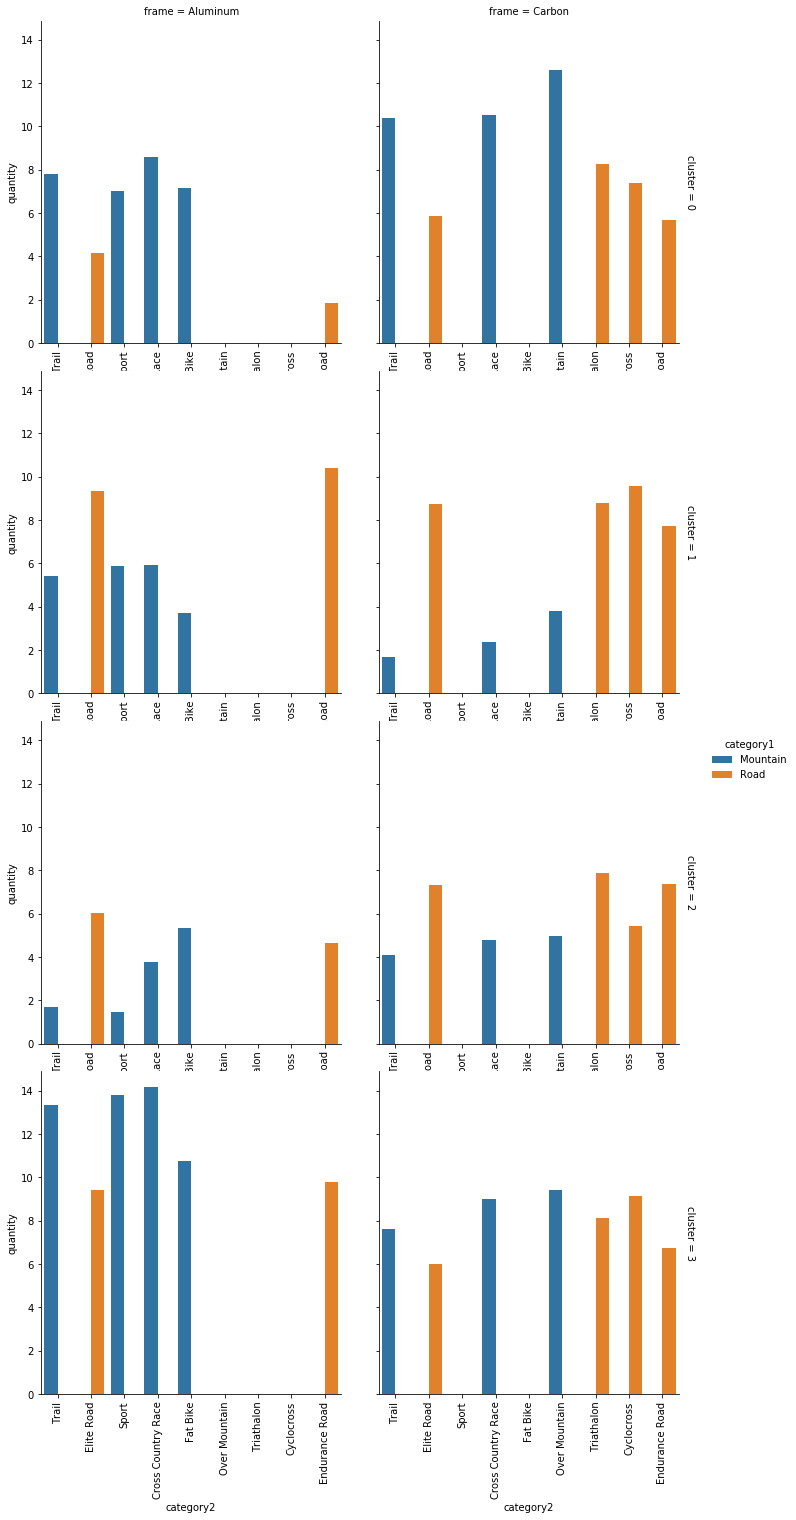

In [17]:
g=sns.catplot(data=df_c,x='category2',y='quantity',hue='category1',col='frame', row='cluster',kind='bar',ci=False, sharex=False,margin_titles=True)
temp=[plt.setp(ax.get_xticklabels(), rotation=90) for ax in g.axes.flat]

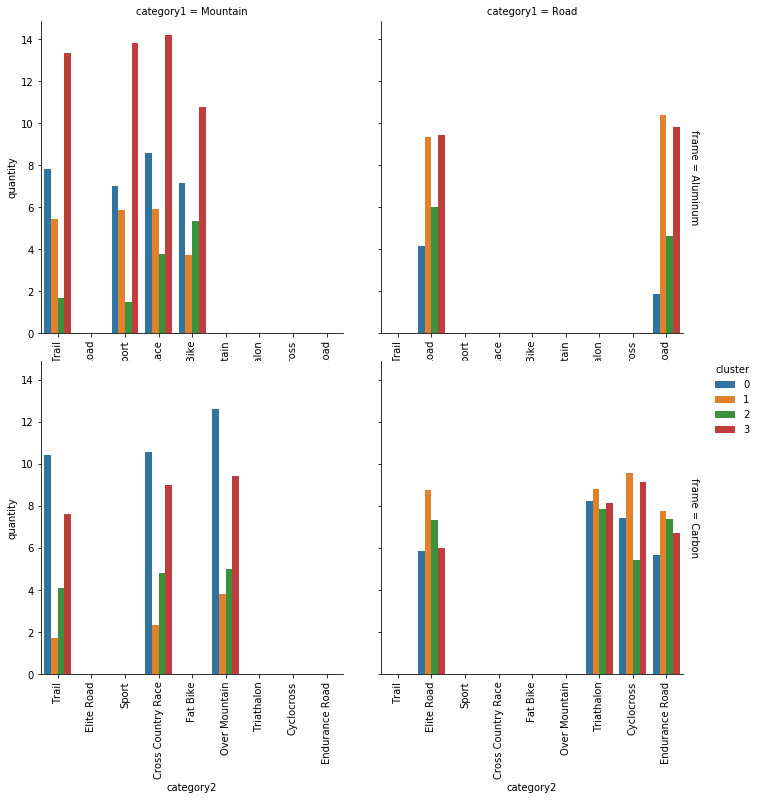

In [18]:
g = sns.catplot(data=df_c,x='category2',y='quantity', col='category1', row='frame', kind='bar',hue='cluster', sharex=False, margin_titles=True,ci=None)
temp=[plt.setp(ax.get_xticklabels(), rotation=90) for ax in g.axes.flat]

# 10. TODO:
- Giải thích ý nghĩa của từng nhóm khách hàng.
- Đề xuất chiến lược bán hàng cho từng nhóm này.